# 9. 선형 회귀 모델

## 데이터 확인

In [ ]:
# warnings => 사이킷런 1.2ver 부터는 보스턴 주택가격 데이터가 없어진다는 경고 메시지 출력 제거

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# sep => separator(구분자)

data_url = 'http://lib.stat.cmu.edu/datasets/boston'
raw_df = pd.read_csv(data_url, sep='\s+', skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [ ]:
boston_df = pd.DataFrame(
    data=data,
    columns=['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT'],
)

boston_df['PRICE']=target
boston_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


## Feature와 Feature의 상관관계
- 상관관계를 본다는 것 => Feature가 Target을 예측하는데 있어서 결정적인 역할을 하는가?
- 다중공선성 여부를 확인할 수 있다.
- 상관관계 (correlation)
  - 상관성을 본다는 건 전체적인 데이터의 추세를 본다는 의미이다. 따라서 값이 아닌 히트맵 색깔로 판단 후 차원 축소 or 특징 추출 등을 수행한다.
  - 단순히 상관관계 계수만 보고 판단하기 어렵기 때문에, 머신러닝 모델링에서는 전문가 고문을 얻는 경우가 많다. 비즈니스 조언이 필요한 영역이기 때문에 전공 지식을 도메인으로 머신러닝과 합치는 방향성이 가장 좋다.

In [ ]:
# np.abs => 절대값 함수
#   corr() => 각 열 간의 상관 계수를 반환하는 메서드
#   sort_values() => 값을 기준으로 레이블을 정렬하는 메서드

np.abs(
    boston_df.corr()['PRICE']
).sort_values()

CHAS       0.175260
DIS        0.249929
B          0.333461
ZN         0.360445
AGE        0.376955
RAD        0.381626
CRIM       0.388305
NOX        0.427321
TAX        0.468536
INDUS      0.483725
PTRATIO    0.507787
RM         0.695360
LSTAT      0.737663
PRICE      1.000000
Name: PRICE, dtype: float64

In [ ]:
boston_df.corr()['PRICE'].sort_values()

LSTAT     -0.737663
PTRATIO   -0.507787
INDUS     -0.483725
TAX       -0.468536
NOX       -0.427321
CRIM      -0.388305
RAD       -0.381626
AGE       -0.376955
CHAS       0.175260
DIS        0.249929
B          0.333461
ZN         0.360445
RM         0.695360
PRICE      1.000000
Name: PRICE, dtype: float64

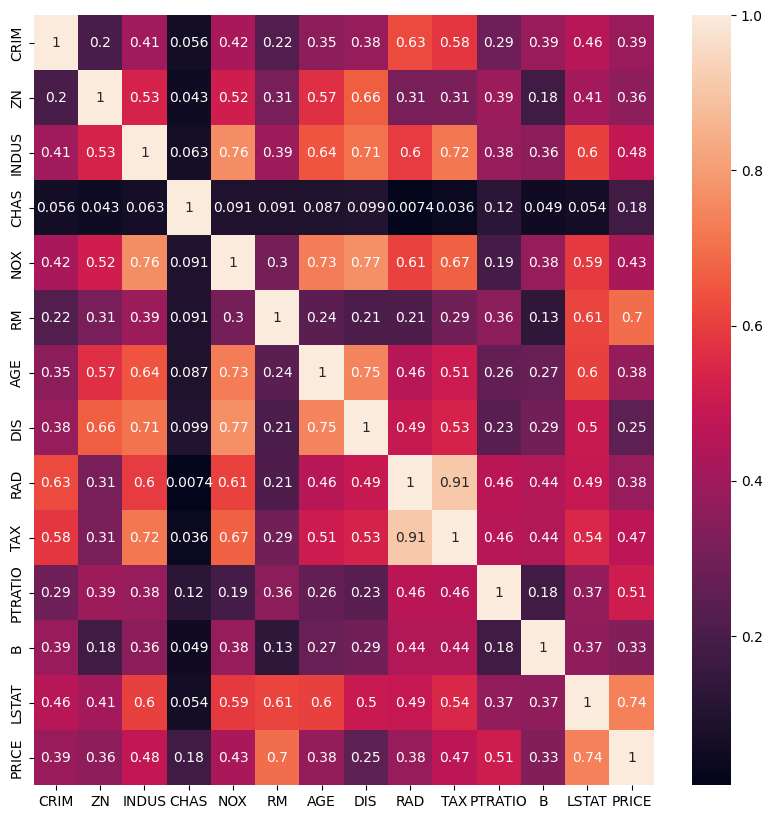

In [ ]:
# pearson 상관계수는 -1에서 1 사이의 값이기 때문에 절대값을 씌워서 색만 확인한다.
# corr_matrix_pos => 보스턴 데이터프레임의 상관관계를 절대값으로 확인
#                    어떤 feature와 feature, feature와 target 간 관계성이 높은지 확인하기 위함
# heatmap(annot=True) => 히트맵 내부에 숫자로 값을 표시

corr_matrix_pos = np.abs(boston_df.corr())

plt.figure(figsize=(10, 10))

sns.heatmap(
    data=corr_matrix_pos,
    annot=True
)

plt.show()

## 데이터 분할

In [ ]:
# train_test_split() => (X, y, 파라미터 요소들)
#   X: boston_df.drop('PRICE', axis=1) => train의 'PRICE' 열을 제외한 데이터를 분리
#   y: boston_df['PRICE']

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(
    boston_df.drop('PRICE', axis=1),
    boston_df['PRICE'],
    test_size=0.2,
    random_state=42
)

## 모델 훈련

In [ ]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

LinearRegression()

## 예측

In [ ]:
y_pred = lr_reg.predict(X_test)
y_pred
y_pred[:3]

array([28.99672362, 36.02556534, 14.81694405])

## 예측 성능 평가하기
- Loss 활용
- 머신러닝 회귀 알고리즘은 데이터를 계속 학습하면서 손실함수가 반환하는 값, 즉 오류값을 감소시키는데 목적이 있다.
  - Loss Function(손실함수) == Cost Function(비용함수)
  - RSS = MSE => 오류값의 제곱
    - 오류값 = 실제값 - 예측값

In [ ]:
# mean_squared_error() => mse값 = 실제값-예측값
#   np.sqrt() => 제곱근 결과를 반환
#   RMSE^2 = MSE

from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('MSE: {}'.format(mse))
print('RMSE: {}'.format(rmse))

MSE: 24.291119474973478
RMSE: 4.928602182665332


In [ ]:
# R^2 => 분산 기반으로 예측 성능을 평가하는 지표. 회귀에서의 정확도에 해당한다.
#        1에 가까울수록 예측 정확도가 높아진다.

r2 = r2_score(y_test, y_pred)
print('R2: {}'.format(r2))

R2: 0.6687594935356326


## 교차 검증
- MSE 사용 ~ 평균 RMSE까지 구하기
- 폴드 세트의 추출, 학습, 예측, 평가를 한번에 수행

In [ ]:
# scoring => 예측 평가 방법
#   neg_mean-squared_error => 사이킷런의 교차검증 기능은 scoring 매개변수에서 클수록 좋은 평가를 내린다.
#                             MSE(오차제곱합) 값 자체는 낮을수록 좋기 때문에, scoring 변수에 맞게 음수(neg)를 적용한 것

from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    LinearRegression(),
    X_train,
    y_train,
    cv=5,
    scoring='neg_mean_squared_error'
)

scores

array([-17.20183677, -34.40858715, -23.73328987, -20.28446607,
       -22.6439115 ])

In [ ]:
# RMSE 구하는 과정
#   scores 변수 정의할 때 평가를 위해 mse에 음수를 곱한 것을 다시 원래대로 돌려준다. (-1 곱하기)
#   np.sqrt를 이용하여 mse의 제곱근 == rmse를 구한다.

mse_scores = -1 * scores
rmse_scores = np.sqrt(mse_scores)

# 평균 rmse
rmse_mean = np.mean(rmse_scores)
rmse_mean

4.829493065236907

In [ ]:
# 하기 내용으로 데이터 분석이 필요하다.
#   R^2 =>위에서 보스턴 주택 가격의 R^2가 약 0.67 나왔다.
#         보통 실무에서 R^2가 0.70 이상이면 대박, R^2가 40 이상이면 그럭저럭 괜찮은 편
#         보스턴 데이터는 깔끔하게 정제된 데이터이기 때문에 0.67로 높은 수준된 것으로 예상
#   std(표준편차)가 rmse보다 크면 나쁘지 않은 수준인 것 (std:9.20 > rmse_mean:4.83)
boston_df['PRICE'].describe()

count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: PRICE, dtype: float64

**상관관계 확인 - 데이터 분할 - 훈련 - 예측 - 평가 - 교차검증**

## 다항회귀 (PolynomialFeatures)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

sample = np.arange(6).reshape(3, 2)
print('일차 단항식 feature: \n{}'.format(sample))

일차 단항식 feature: 
[[0 1]
 [2 3]
 [4 5]]


In [ ]:
# degree => 차수를 의미. 몇 차 다항식을 만들지 결정
#   일차식 sample 리스트를 이차다항식 poly 객체에 학습시킨다.

poly = PolynomialFeatures(degree=2)
poly.fit(sample)

poly_trf = poly.transform(sample)
print('이차 다항식 feature: \n{}'.format(poly_trf))

이차 다항식 feature: 
[[ 1.  0.  1.  0.  0.  1.]
 [ 1.  2.  3.  4.  6.  9.]
 [ 1.  4.  5. 16. 20. 25.]]


## 다항 회귀를 활용한 보스턴 주택 가격

In [ ]:
# 훈련 세트를 다차식으로 만들었다. => 테스트 세트도 다차식으로 만들어야 한다.

boston_poly = PolynomialFeatures(degree=2, include_bias=False)

X_poly_2 = boston_poly.fit_transform(X_train)
X_poly_2.shape, X_train.shape

((404, 104), (404, 13))

In [ ]:
# 테스트 세트도 다차식으로 변환
#   테스트 세트를 transform 할 때는 반드시 훈련 데이터의 transformer를 사용해야 한다. (boston_poly)
#   절대로 transformer를 새롭게 만들어서 테스트 세트에 적용시키면 안된다! (계산이 꼬임)

X_poly_test_2 = boston_poly.transform(X_test)
X_poly_test_2.shape, X_test.shape

((102, 104), (102, 13))

**다항 회귀 훈련**

In [ ]:
# 다차항이 추가된 feature로 훈련
#   feature 훈련 데이터, label 훈련 데이터 학습

lr_reg_poly = LinearRegression().fit(X_poly_2, y_train)

In [ ]:
# 다차항이 추가된 feature 예측 (⭐예측은 test 값 사용하는 것 기억!⭐)

y_test_pred = lr_reg_poly.predict(X_poly_test_2)

In [ ]:
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

In [ ]:
print("MSE: {:.3f}".format(test_mse))
print("RMSE: {:.3f}".format(test_rmse))
print("R^2: {:.3f}".format(test_r2))

MSE: 14.257
RMSE: 3.776
R^2: 0.806


## ⭐[참고] StandardScaling과 선형 회귀⭐

In [ ]:
# 표준화
#   훈련 세트에 의해 계산된 평균과 표준편차를 사용한다. (테스트 세트 사용X)
#   테스트 세트의 스케일러를 따로 만들게 되면 원본 데이터의 모수가 바뀜에 주의!
#   즉 테스트 세트에는 fit 하지 말고 transform만 하라는 의미

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 표준화 처리된 데이터를 선형회귀 모델로 훈련

lr_reg_scaled = LinearRegression().fit(X_train_scaled, y_train)

In [ ]:
# 예측 및 MSE, RMSE 값 확인
from sklearn.metrics import mean_squared_error, r2_score

y_pred = lr_reg_scaled.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("MSE: {}".format(mse))
print("RMSE: {}".format(rmse))

MSE : 24.291119474973513
RMSE : 4.928602182665336


- 그냥 선형회귀 모델로 훈련했을때와, standardscaler= 후 선형회귀 모델로 훈련했을 때의 MSE, RMSE가 동일하다
  - 보통은 선형회귀에서 standardscaling 많이 적용하며, 보통 더 좋은 값을 출력한다.
- 다항회귀로 훈련했을 때의 MSE, RMSE 값이 훨씬 낮기 때문에, 보스턴 주택 가격 데이터 세트는 다차식을 활용하는 것이 더 유리함을 알 수 있다.

# 10. 과소적합과 과대적합

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
%matplotlib inline

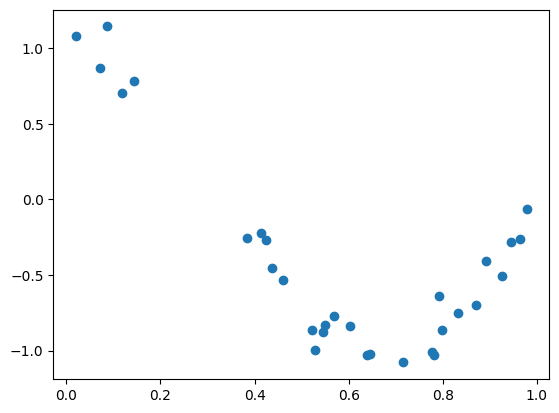

In [2]:
# random_seed() => random 무작위의 결과를 특정한 값으로 고정

def true_fun(X):
  return np.cos(1.5 * np.pi * X)

np.random.seed(0)
n_samples = 30
X = np.sort(np.random.rand(n_samples))

y = true_fun(X) + np.random.randn(n_samples) * 0.1
plt.scatter(X, y)


Degree 1 회귀 계수는 [-1.61] 입니다
Degree 1 MSE는  0.41입니다

Degree 4 회귀 계수는 [  0.47 -17.79  23.59  -7.26] 입니다
Degree 4 MSE는  0.04입니다

Degree 15 회귀 계수는 [-2.98293000e+03  1.03899390e+05 -1.87416123e+06  2.03716219e+07
 -1.44873283e+08  7.09315363e+08 -2.47065792e+09  6.24561050e+09
 -1.15676510e+10  1.56894936e+10 -1.54006023e+10  1.06457264e+10
 -4.91377530e+09  1.35919645e+09 -1.70380786e+08] 입니다
Degree 15 MSE는  181238256.56입니다


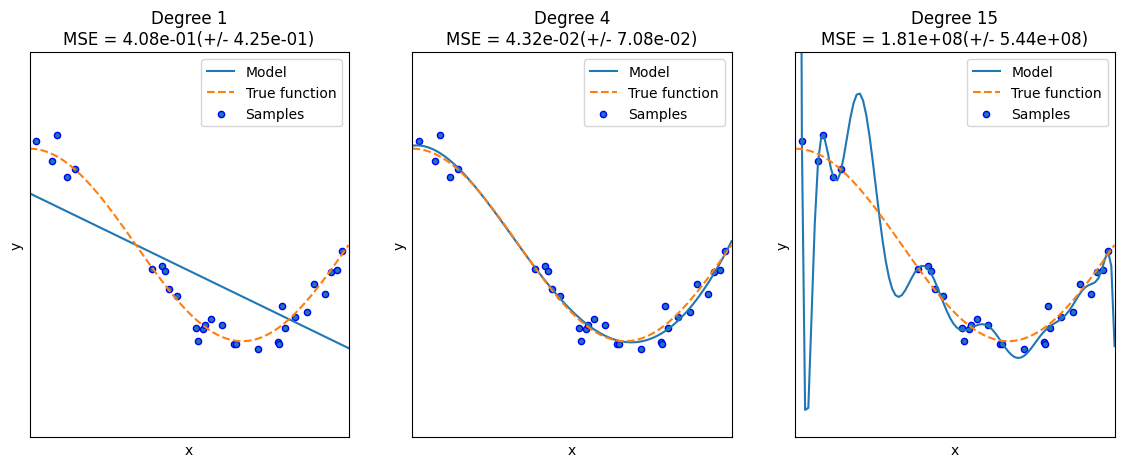

In [3]:
# degrees => 다항회귀의 차수(degree)를 1, 4, 15로 각각 변화시키며 비교
# Pipeline() => 데이터 전처리에서 학습까지의 과정을 하나로 연결해주는 것
# coef_ => 계수, 기울기

# degree4 => 4차식(계수가 4개)
#   degree15는 15차식으로 가중치가 과도하게 커진 것을 확인할 수 있.
#   개수와 상관없이, 가중치의 값이 클수록 분산이 커진다.
#   분산은 y값에 따라 달라진다.
#   가중치가 클수록 불리해지기 때문에 가중치 규제를 통해 조절하는 것
#   분산이 커지면 모델이 복잡하게 해석할 가능성이 크기 때문에 과대적합인 경우가 다
#   일반적으로 데이터가 많아지면 w(가중치)는 내려간다.
#   degree1은 훈련 세트와 테스트 세트에 대한 오차가 모두 크다.
#   degree15는 훈련 세트에 대한 오차는 작지만 테스트 세트에 대한 오차는 크다.
#   아래는 valid set에 대한 오차의 시각화

plt.figure(figsize=(14, 5))
degrees = [1, 4, 15]

for i in range(len(degrees)):
  ax = plt.subplot(1, len(degrees), i + 1)
  plt.setp(ax, xticks=(), yticks=())

  polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
  linear_regression = LinearRegression()
  pipeline = Pipeline([('polynomial_features', polynomial_features),
                       ('linear_regression', linear_regression)])
  pipeline.fit(X.reshape(-1, 1), y)

  scores = cross_val_score(pipeline, X.reshape(-1, 1), y, scoring='neg_mean_squared_error', cv=10)
  coefficients = pipeline.named_steps['linear_regression'].coef_
  print('\nDegree {0} 회귀 계수는 {1} 입니다'.format(degrees[i], np.round(coefficients, 2)))
  print('Degree {0} MSE는 {1: .2f}입니다'.format(degrees[i], -1*np.mean(scores)))

  X_test = np.linspace(0, 1, 100)

  plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")

  plt.plot(X_test, true_fun(X_test), '--', label="True function")
  plt.scatter(X, y, edgecolor='b', s=20, label="Samples")

  plt.xlabel("x"); plt.ylabel("y"); plt.xlim((0, 1)); plt.ylim((-2, 2)); plt.legend(loc="best")
  plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(degrees[i], -scores.mean(), scores.std()))

plt.show()

## 규제 선형 회귀

alpha 10 : [-0.28 -0.18 -0.1  -0.05 -0.01  0.01  0.02  0.03  0.04  0.04  0.05  0.05
  0.05  0.05  0.05] 입니다.
alpha 10 MSE 는 0.48 입니다.
alpha 1 : [-1.26 -0.66 -0.24 -0.    0.12  0.19  0.21  0.22  0.21  0.2   0.19  0.18
  0.16  0.15  0.14] 입니다.
alpha 1 MSE 는 0.22 입니다.
alpha 0.1 : [-2.8  -0.98  0.11  0.58  0.71  0.67  0.56  0.42  0.29  0.16  0.05 -0.05
 -0.13 -0.2  -0.25] 입니다.
alpha 0.1 MSE 는 0.06 입니다.
alpha 0.01 : [-3.43 -1.29  0.39  1.09  1.2   1.01  0.71  0.41  0.15 -0.05 -0.2  -0.29
 -0.34 -0.35 -0.33] 입니다.
alpha 0.01 MSE 는 0.02 입니다.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.60394e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


alpha 0 : [-2.98293000e+03  1.03899390e+05 -1.87416123e+06  2.03716219e+07
 -1.44873283e+08  7.09315363e+08 -2.47065792e+09  6.24561050e+09
 -1.15676510e+10  1.56894936e+10 -1.54006023e+10  1.06457264e+10
 -4.91377530e+09  1.35919645e+09 -1.70380786e+08] 입니다.
alpha 0 MSE 는 181238256.78 입니다.


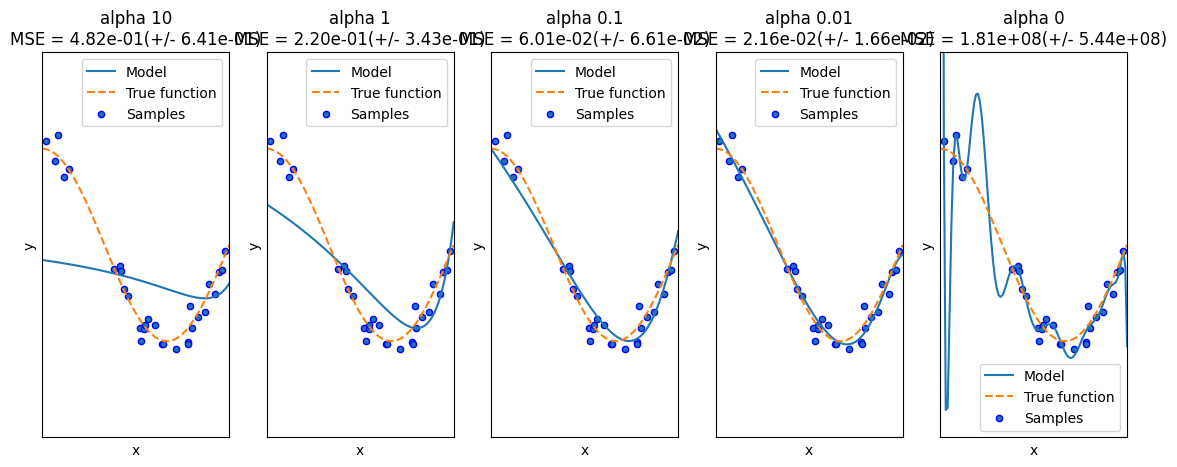

In [4]:
from sklearn.linear_model import Ridge

plt.figure(figsize=(14, 5))
alphas = [10, 1, 0.1, 0.01, 0]

for i in range(len(alphas)):
    ax = plt.subplot(1, len(alphas), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=15, include_bias=False)
    ridge = Ridge(alpha=alphas[i])
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", ridge)])
    pipeline.fit(X.reshape(-1, 1), y)

    scores = cross_val_score(pipeline, X.reshape(-1,1), y,scoring="neg_mean_squared_error", cv=10)
    coefficients = pipeline.named_steps['linear_regression'].coef_
    print('alpha {0} : {1} 입니다.'.format(alphas[i], np.round(coefficients, 2)))
    print('alpha {0} MSE 는 {1:.2f} 입니다.'.format(alphas[i], -1*np.mean(scores)))

    X_test = np.linspace(0, 1, 100)

    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")

    plt.plot(X_test, true_fun(X_test), '--', label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")

    plt.xlabel("x"); plt.ylabel("y"); plt.xlim((0, 1)); plt.ylim((-2, 2)); plt.legend(loc="best")
    plt.title("alpha {}\nMSE = {:.2e}(+/- {:.2e})".format(alphas[i], -scores.mean(), scores.std()))

plt.show()


## 규제 선형회귀를 이용한 보스턴 주택 가격 예측

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [6]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [9]:
boston_df = pd.DataFrame(
    data=data,
    columns=['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']
)

boston_df['PRICE']=target
boston_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


### degree=3으로 준 상태에서의 LinearRegression 성능 확인

In [7]:
from sklearn.metrics import mean_squared_error

def print_score(model, test_data, y_test):
  pred = model.predict(test_data)
  mse = mean_squared_error(y_test, pred)
  print('\nMSE : {:.3f}'.format(mse))

In [10]:
# includes_bias => 절편(0차항, 계수, 가중치)의 유무

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

boston_poly = PolynomialFeatures(degree=3, include_bias=False)

X_train, X_test, y_train, y_test = train_test_split(
    boston_df.drop('PRICE', axis=1),
    boston_df['PRICE'],
    test_size=0.2,
    random_state=42
)

X_train_3 = boston_poly.fit_transform(X_train)
X_test_3 = boston_poly.transform(X_test)

In [11]:
X_train_3.shape, X_test_3.shape

((404, 559), (102, 559))

In [12]:
# 선형회귀 모델링
#   X는 3차식, y는 원본 그대로!
#   print_score => 위에서 MSE 값 구하는 함수 정의
#   테스트 세트의 MSE 값으로 알 수 있듯 과대적합 확인된다.

from sklearn.linear_model import LinearRegression

lr_reg = LinearRegression().fit(X_train_3, y_train)
print_score(lr_reg, X_train_3, y_train)
print_score(lr_reg, X_test_3, y_test)


MSE : 0.000

MSE : 129847.995


In [13]:
# 가중치 확인

lr_reg.coef_

array([-7.51886506e-01, -3.80909396e+00, -1.06645442e+00, -2.14848458e-03,
       -4.77764291e-02, -4.12817415e-01,  5.19697092e+01, -2.49332378e+00,
        3.47515164e+00,  2.05253674e+01,  1.50290326e+00, -1.97278841e+01,
        3.23291414e-01, -1.15914767e+01, -1.06288961e+01,  1.85791929e+00,
       -9.34481016e-03,  1.87630138e+00,  5.97462993e+00, -7.09135741e+00,
       -9.83862902e+00,  5.61231782e+00,  3.02785956e+00, -8.27344044e+00,
       -1.83110683e+00, -2.02973592e+01, -1.57726454e+00, -1.37901955e+01,
       -2.45327477e-03, -7.90415760e+00,  9.33196579e+00, -1.15835208e+00,
        1.12385316e+01, -6.82716921e+00,  8.67243435e-01,  9.19531105e-02,
       -1.83479749e-01, -4.23331033e+00, -1.77800582e+01, -1.12536653e-02,
        1.31358386e+00, -3.64615246e+01, -1.42562721e+01,  7.57016398e+00,
       -9.52876608e+00,  5.62807062e+00, -1.27710321e+01, -1.46435984e+00,
        2.31063786e+01, -2.17709203e-03, -1.78582665e-04, -6.33504839e-03,
       -6.64131822e-02,  

### Ridge를 이용한 가중치 규제

In [14]:
# Ridge는 알파값이 커질수록 가중치가 늘어난다.

from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=10).fit(X_train_3, y_train)
print_score(ridge_reg, X_train_3, y_train)
print_score(ridge_reg, X_test_3, y_test)


MSE : 3.316

MSE : 169.674


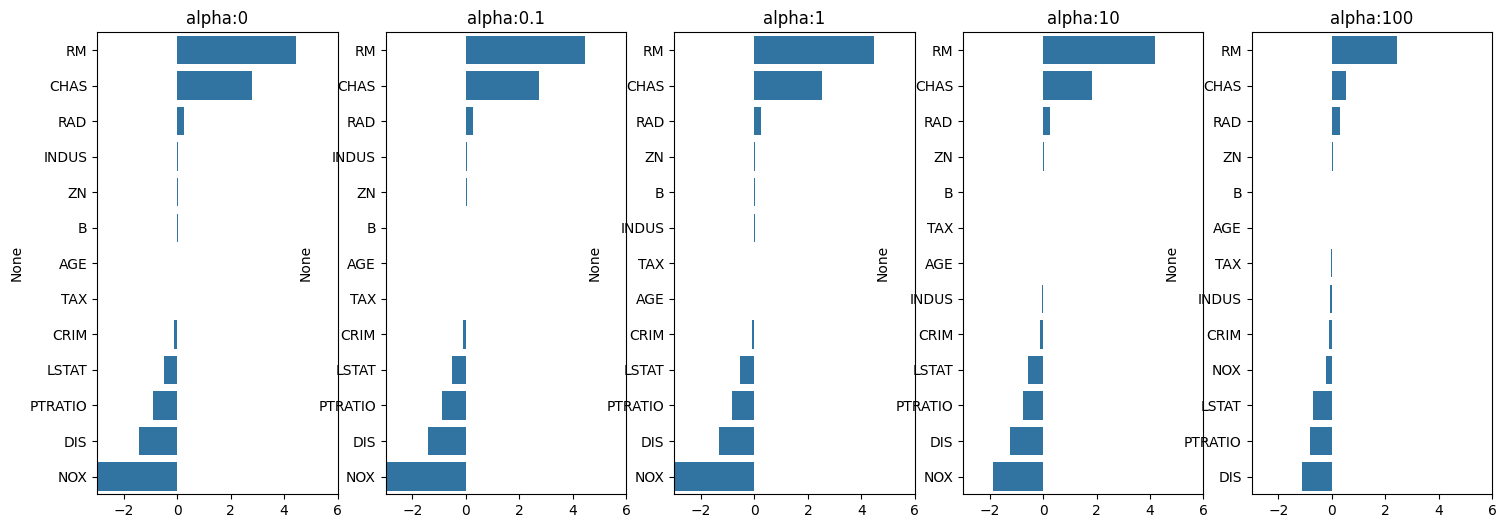

In [16]:
# 알파값에 따른 회귀 계수 값 시각화 => matplotlib 생성
#   pos => axis 위치
#   barplot으로 알파값에서의 회귀 계수를 높은 순으로 시각화


alphas = [0 , 0.1 , 1 , 10 , 100]

fig , axs = plt.subplots(figsize=(18,6) , nrows=1 , ncols=5)

coeff_df = pd.DataFrame()

for pos, alpha in enumerate(alphas) :
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_train , y_train)

    coeff = pd.Series(data=ridge.coef_ , index=X_train.columns )
    colname='alpha:'+str(alpha)
    coeff_df[colname] = coeff

    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,6)
    sns.barplot(x=coeff.values , y=coeff.index, ax=axs[pos])

plt.show()

### Lasso를 이용한 규제 선형회귀

In [15]:
# Lasso는 (Ridge와 달리) 알파값이 커질수록 가중치가 줄어든다.
#   계속 줄어들다 없어지기도 한다.

from sklearn.linear_model import Lasso

lr_lasso = Lasso(alpha=10).fit(X_train, y_train)

In [17]:
lr_lasso.coef_

array([-0.        ,  0.00632092, -0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        , -0.0090727 ,
       -0.        ,  0.00989229, -0.60414765])

In [18]:
lr_ridge = Ridge(alpha=10).fit(X_train, y_train)
lr_ridge.coef_

array([-0.10713363,  0.03555248, -0.02627747,  1.81329133, -1.88924475,
        4.19532572, -0.01534126, -1.23262135,  0.24803063, -0.01274419,
       -0.76176896,  0.01283334, -0.561835  ])

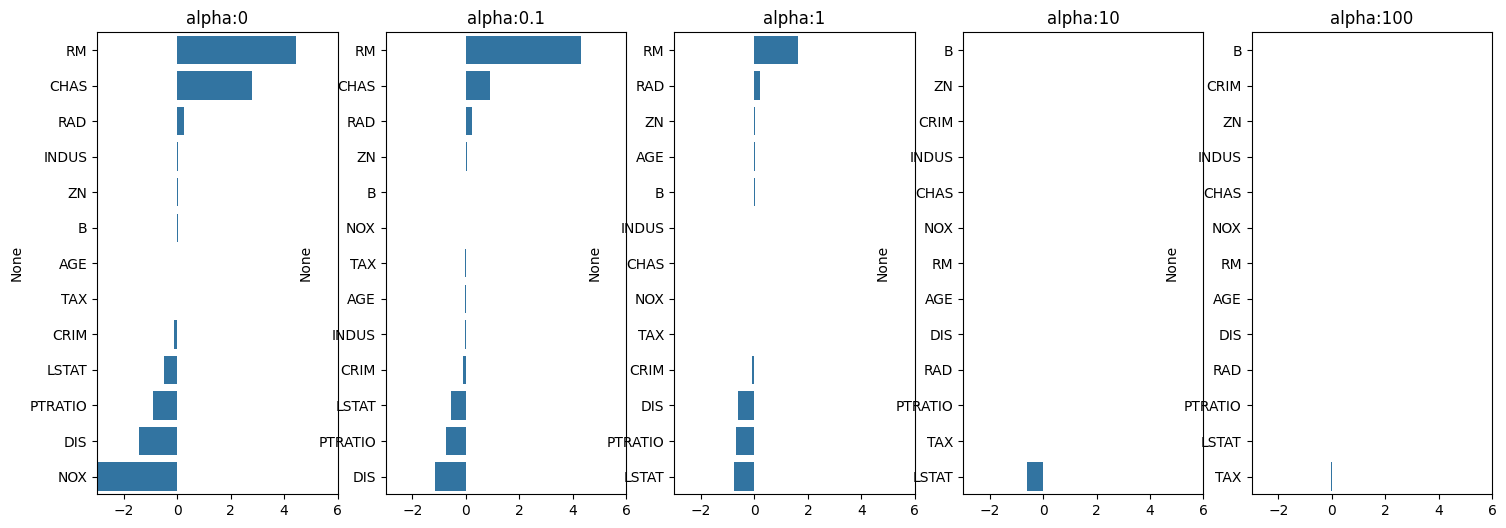

In [19]:
# 알파값에 따른 회귀 계수 값 시각화 => matplotlib 생성
#   pos => axis 위치
#   barplot으로 알파값에서의 회귀 계수를 높은 순으로 시각화

alphas = [0 , 0.1 , 1 , 10 , 100]

fig , axs = plt.subplots(figsize=(18,6) , nrows=1 , ncols=5)

coeff_df = pd.DataFrame()

for pos , alpha in enumerate(alphas) :
    lasso = Lasso(alpha = alpha)
    lasso.fit(X_train , y_train)

    coeff = pd.Series(data=lasso.coef_ , index=X_train.columns )
    colname='alpha:'+str(alpha)
    coeff_df[colname] = coeff

    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,6)
    sns.barplot(x=coeff.values , y=coeff.index, ax=axs[pos])

plt.show()